In [115]:
# This script uses Inext to create figures about the increasing number
# of species

# ================================================================================================

# Loading required Libraries
# rio: A Swiss-Army Knife for Data I/O, it simplifies the process of importing and exporting data in R
# tidyverse: Collection of R packages designed for data science
# patchwork: It allows us to combine separate ggplots into the same graphic
# ggtext: Improves the rendering of text in ggplot2
# cowplot: Provides various features that help with creating publication-quality figures with ggplot
library(rio)
library(tidyverse)
library(patchwork)
library(ggtext)
library(cowplot)

# No warnings ------------------------------------------------------------------
options(warn = -1)

# Session info ------------------------------------------------------------------
sessionInfo()

In [116]:
# -------------------
# Importing the complementary data from an Excel file
# Following operations are performed:
# 1. import(): reads the excel sheet "survey_info_hosts"
# 2. rename(): changes the name 'host_complete_name' to 'host_species'
# 3. distinct() : keeps the unique rows based on 'host_species'
# 4. select(): drops the 'lonomia_species' column
hosts_info <- rio::import("/home/jovyan/work/hospedadores_lonomia/data/hosts.xlsx",
    sheet = "survey_info_hosts"
) |>
    rename(host_especies = host_complete_name) |>
    distinct(host_especies, .keep_all = T) |>
    select(-lonomia_species)

# Checking the dimensions of hosts_info
hosts_info |> str()

'data.frame':	60 obs. of  24 variables:
 $ host_especies              : chr  "Prunus domestica" "Melia azedarach" "Mespilus germanica" "Persea americana" ...
 $ genus                      : chr  "Prunus" "Melia" "Mespilus" "Persea" ...
 $ specific_epithet           : chr  "domestica" "azedarach" "germanica" "americana" ...
 $ canonical_author           : chr  "L." "L." "L." "Mill." ...
 $ family                     : chr  "Rosaceae" "Meliaceae" "Rosaceae" "Lauraceae" ...
 $ status                     : chr  "Cultivated" "Naturalized" "Cultivated" "Cultivated" ...
 $ native                     : chr  "no" "no" "no" "no" ...
 $ endemic_south_america      : chr  NA NA NA NA ...
 $ endemic_biome_south_america: chr  NA NA NA NA ...
 $ use_popular_medicine       : chr  "yes" "yes" "yes" "yes" ...
 $ use_consume_fruits         : chr  "yes" "no" "yes" "yes" ...
 $ fruit_popular_name         : chr  "plum" "chinaberry" "medlar" "avocado" ...
 $ use_fruits_commercialized  : chr  "yes" "no" "yes" 

In [117]:
# -------------------
# Importing the main data from the same Excel file but different sheet 'lonomia_host'
# Following operations are performed:
# 1. right_join(): merges 'hosts_info' onto 'initial_data' based on 'host_species'
# 2. replace_na() : replaces NA values in 'native' column with 'no info.'
# 3. factor(): factors the 'native' column with levels ordered as 'yes', 'no', 'no info.'
initial_data <- rio::import("/home/jovyan/work/hospedadores_lonomia/data/hosts.xlsx",
    sheet = "lonomia_host"
) |>
    right_join(hosts_info, by = "host_especies") |>
    mutate(native = replace_na(native, "no info.")) |>
    mutate(Native = factor(native, levels = c("yes", "no", "no info.")))

# Checking the dimensions of initial_data
initial_data |> str()

'data.frame':	116 obs. of  34 variables:
 $ lonomia_species            : chr  "Lonomia achelous" "Lonomia achelous" "Lonomia obliqua" "Lonomia obliqua" ...
 $ host_especies              : chr  "Tapirira guianensis" "Tapirira guianensis" "Bauhinia forficata" "Platanus acerifolia" ...
 $ host_family                : chr  "Anacardiaceae" "Anacardiaceae" "Fabaceae" "Platanaceae" ...
 $ popular_name_host          : chr  NA NA NA NA ...
 $ year_s                     : chr  "1996" "1996" "1996" "2003" ...
 $ min_year                   : num  1996 1996 1996 2003 2013 ...
 $ country                    : chr  "Venezuela" "Venezuela" "Brazil" "Brazil" ...
 $ reference_type             : chr  "Scientific article" "Scientific article" "Scientific article" "Scientific article" ...
 $ references                 : chr  "Lucena et al. 2006" "Marval et al. 1999" "Duarte et al. 1997" "Specht et al. 2009" ...
 $ distribution_overlap       : chr  "yes" "yes" "yes" "yes" ...
 $ genus                      : 

In [118]:
# -------------------
# This function aggregates data based on a variable 'x' which can be host species,
# host family or host genera. The purpose of this function is to calculate how many
# times a specific host (species/family/genera) is associated with a particular
# lonomia species.

agg_function <- function(data, x) {
  # Selecting required columns from the input dataframe 'data' and removing duplicates.
  # '{{x}}' allows you to splice a variable into the function argument.
  # 'distinct()' is used here to get unique combinations of lonomia_species, x, min_year and Native for each year.
  select(data, lonomia_species, {{ x }}, min_year, Native) |>
    distinct(lonomia_species, {{ x }}, min_year, .keep_all = T) |>
    # Group data by lonomia_species and x, then calculate the minimum year for each group.
    # 'group_by()' creates groups of rows containing same values in specified columns.
    # 'mutate()' transforms or adds new variables to a dataframe.
    group_by(lonomia_species, {{ x }}) |>
    mutate(min_year = min(min_year)) |>
    # Again remove duplicates after transforming the min_year value.
    # This step ensures that we will only count the first occurrence of the host for a given lonomia_species.
    distinct(lonomia_species, {{ x }}, min_year, Native) |>
    # Create a group with respect to three variables and add a new column named 'caso' filled with 1s.
    # To represent the occurrences at the level of x, we again need to regroup the data.
    group_by(lonomia_species, min_year, Native) |>
    mutate(caso = 1) |>
    # Summarize data to get the total_in_that_year for each group.
    # 'summarise()' is used here to reduce multiple values down to a single summary.
    summarise(total_in_that_year = sum(caso)) |>
    # Calculate cumulative sum of total_in_that_year to get 'aggregate_n_for_that_year'.
    # 'cumsum()' computes the cumulative sum of numeric input.
    mutate(aggregate_n_for_that_year = cumsum(total_in_that_year))
}

# -------------------
# The 'agg_function' is called on the 'initial_data' dataframe using 'host_especies' as the variable 'x'.
# The output of this function call will give aggregated counts of each unique combination of lonomia species 
# and host species for each year. This aggregation is assigned to the variable 'host_species'.
host_species <- initial_data |> agg_function(host_especies)

# 'str()' is a compact display function in R. 
# It's used here to display the internal structure of an R object, in this case, 'host_species'.
# str() provides a more human-readable output than just printing the dataframe, especially when it comes to large dataframes. 
# It can be helpful for getting a quick understanding of the data you're working with.
host_species |> str()

`summarise()` has grouped output by 'lonomia_species', 'min_year'. You can
override using the `.groups` argument.


gropd_df [25 × 5] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ lonomia_species          : chr [1:25] "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" ...
 $ min_year                 : num [1:25] 1978 1979 2010 2010 2020 ...
 $ Native                   : Factor w/ 3 levels "yes","no","no info.": 1 1 1 2 1 1 2 1 1 2 ...
 $ total_in_that_year       : num [1:25] 1 1 2 1 4 4 2 1 6 7 ...
 $ aggregate_n_for_that_year: num [1:25] 1 1 2 3 4 4 2 1 6 13 ...
 - attr(*, "groups")= tibble [18 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ lonomia_species: chr [1:18] "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" ...
  ..$ min_year       : num [1:18] 1978 1979 2010 2020 1989 ...
  ..$ .rows          : list<int> [1:18] 
  .. ..$ : int 1
  .. ..$ : int 2
  .. ..$ : int [1:2] 3 4
  .. ..$ : int 5
  .. ..$ : int 6
  .. ..$ : int 7
  .. ..$ : int 8
  .. ..$ : int [1:2] 9 10
  .. ..$ : int [1:2] 11 12
  .. ..$ : int [1:2] 13 14
  .. ..$ : int 15
  .. ..$ : int 1

In [119]:
# -------------------
# The 'dplyr' package in the R language provides the 'select()' functions.
# The 'select()' function is used to subset the dataset by selecting specific columns.
# In this case, we're choosing 'lonomia_species', 'host_especies', 'min_year', and 'Native' from 'initial_data'.
initial_data |>
    select(lonomia_species, host_especies, min_year, Native) |>
    # Next, we are applying the 'distinct()' function to remove duplicate rows from the dataframe.
    # The 'distinct()' function takes the name of the columns (in this case, 'lonomia_species', 'host_especies', 'min_year')
    # on which to base the elimination of duplicates.

    # The argument '.keep_all = T' is to control the selection of other non-specified columns in the dataframe.
    # By setting it to TRUE (T), we retain all other columns in the output, not just the ones you've specified.
    distinct(lonomia_species, host_especies, min_year, .keep_all = T) |>
    head()

,lonomia_species,host_especies,min_year,Native
,<chr>,<chr>,<dbl>,<fct>
1,Lonomia achelous,Tapirira guianensis,1996,yes
2,Lonomia obliqua,Bauhinia forficata,1996,yes
3,Lonomia obliqua,Platanus acerifolia,2003,no
4,Lonomia obliqua,Solanum pseudoquina,2013,yes
5,Lonomia obliqua,Sebastiania brasiliensis,2014,yes
6,Lonomia obliqua,Nectandra grandiflora,2014,yes


In [120]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Functions

# -------------------
# Defining a function named 'plot_preparer' which takes four arguments: 'data', 'filter', 'aggregation', and 'completion'.
plot_preparer <- function(data, filter, aggregation, completion){
  # Filtering the data based on a condition where specified 'aggregation' column value contains the 'filter'. 
  # The 'str_detect()' function is used to detect the presence of 'filter' within each element of the 'aggregation' column.
  filter(data, str_detect({{aggregation}}, filter)) |>

  # Using 'ungroup()' to remove grouping from the data. This can be useful to perform operations that should not respect the grouping structure.
  ungroup() |>
  
  # Using 'select()' function to deselect or drop the 'aggregate_n_for_that_year' and specific 'aggregation' column from the dataframe.
  select(-aggregate_n_for_that_year,-{{aggregation}}) |>
  
  # 'complete()' function is used to complete the missing combinations of data values with specific replacements.
  # Here, it fills in the missing 'min_year' entries with the given 'completion' and 'Native' columns.
  complete(min_year = c(completion), Native) |>

  # Using 'mutate()' function to add new variable 'total_in_that_year'. 
  # It replaces NA values with 0 and keeps all other values the same for this particular variable.
  mutate(total_in_that_year = case_when(is.na(total_in_that_year) ~ 0,
                                        TRUE ~ total_in_that_year)) |>

  # Grouping the dataframe by 'Native' column.
  group_by(Native) |>

  # Adding a new variable 'aggregate_n_for_that_year' which represents cumulative sum of 'total_in_that_year' within each group.
  # The 'cumsum()' function is used to calculate the cumulative sum.
  mutate(aggregate_n_for_that_year =
           cumsum(total_in_that_year))
}

# -------------------
# Defining a function named 'plotter' which takes three arguments: 'data', 'title', and 'ticks'.
plotter <- function(data, title, ticks) {
  # Creating a ggplot object with aesthetics mappings on group, shape, color, y variable, and x variable.
  ggplot(data, aes(
    group = Native, shape = Native, color = Native,
    y = aggregate_n_for_that_year, x = min_year
  )) +

    # Adding a bar layer to the plot using 'geom_bar()'. The bars are stacked on top of each other.
    # 'fill', 'color', and 'width' arguments are used to customize the appearance of bars.
    geom_bar(
      position = "stack", fill = "grey90",
      stat = "identity", color = "grey90", width = 2
    ) +

    # Customizing the colors used in the plot.
    scale_color_manual(values = c("#2DAF35", "#F4B01E", "grey40")) +

    # Adding a line layer to the plot using 'geom_line()'.
    geom_line(linetype = 1, size = 1.1, alpha = 0.5) +

    # Adding a point layer to the plot using 'geom_point()'.
    geom_point(size = 2.1) +

    # Setting labels of the plot - title, x-axis label, and y-axis label.
    labs(
      title = title,
      x = "Year",
      y = "Number of hosts"
    ) +

    # Setting the x-axis limits.
    xlim(1989.5, 2021) +

    # Setting the y-axis behavior - tick spaces and axis limits.
    scale_y_continuous(breaks = ticks, limits = c(0, 70)) +

    # Setting theme of the plot to 'theme_bw()' - a theme with white background.
    theme_bw(base_size = 15) +

    # Customizing other elements of plot appearance - title size and y-axis title.
    theme(
      plot.title = element_markdown(size = 16),
      axis.title.y = element_markdown()
    )
}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [121]:
# -------------------
# Applying the 'agg_function' on 'host_especies' column of the 'initial_data' dataset.
# The result is assigned to the variable 'host_species'. 
# Here, '|>' is a pipe operator that takes the output from the left-hand side and uses it as input for the function call on the right.
host_species <- initial_data |> agg_function(host_especies)

# Printing the internal structure of the 'host_species' object using 'str()' function.
# This includes information about the type of object, its length, and contents.
# Pipe operator '|' is used to feed the 'host_species' as an argument into 'str()' function.
host_species |> str()

`summarise()` has grouped output by 'lonomia_species', 'min_year'. You can
override using the `.groups` argument.


gropd_df [25 × 5] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ lonomia_species          : chr [1:25] "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" ...
 $ min_year                 : num [1:25] 1978 1979 2010 2010 2020 ...
 $ Native                   : Factor w/ 3 levels "yes","no","no info.": 1 1 1 2 1 1 2 1 1 2 ...
 $ total_in_that_year       : num [1:25] 1 1 2 1 4 4 2 1 6 7 ...
 $ aggregate_n_for_that_year: num [1:25] 1 1 2 3 4 4 2 1 6 13 ...
 - attr(*, "groups")= tibble [18 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ lonomia_species: chr [1:18] "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" "Lonomia achelous" ...
  ..$ min_year       : num [1:18] 1978 1979 2010 2020 1989 ...
  ..$ .rows          : list<int> [1:18] 
  .. ..$ : int 1
  .. ..$ : int 2
  .. ..$ : int [1:2] 3 4
  .. ..$ : int 5
  .. ..$ : int 6
  .. ..$ : int 7
  .. ..$ : int 8
  .. ..$ : int [1:2] 9 10
  .. ..$ : int [1:2] 11 12
  .. ..$ : int [1:2] 13 14
  .. ..$ : int 15
  .. ..$ : int 1

In [122]:
# -------------------
# The 'plot_preparer' function is applied on the 'host_species' data. It filters the data for "Lonomia achelous",
# aggregates it based on 'lonomia_species', and specifies the period from 1950 to 2020.
# The result is then passed to the 'plotter' function which produces a plot with title "A) *Lonomia achelous*", 
# and y-axis ticks ranging from 0 to 60, in steps of 5.
species1 <- host_species |> 
  plot_preparer(filter ="Lonomia achelous", 
                aggregation = lonomia_species, 1950:2020 ) |> 
  plotter("A) *Lonomia achelous*",seq(0, 60, by = 5))

# Printing the internal structure of the 'species1' object using 'str()' function.
# This includes information about the type of object, its length, and contents.
# Pipe operator '|' is used to feed the 'species1' as an argument into 'str()' function.
species1 |> str()

List of 9
 $ data       : gropd_df [213 × 5] (S3: grouped_df/tbl_df/tbl/data.frame)
  ..$ min_year                 : num [1:213] 1950 1950 1950 1951 1951 ...
  ..$ Native                   : Factor w/ 3 levels "yes","no","no info.": 1 2 3 1 2 3 1 2 3 1 ...
  ..$ total_in_that_year       : num [1:213] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ aggregate_n_for_that_year: num [1:213] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ .group                   : int [1:213] 1 2 3 1 2 3 1 2 3 1 ...
  ..- attr(*, "groups")= tibble [3 × 2] (S3: tbl_df/tbl/data.frame)
  .. ..$ Native: Factor w/ 3 levels "yes","no","no info.": 1 2 3
  .. ..$ .rows : list<int> [1:3] 
  .. .. ..$ : int [1:71] 1 4 7 10 13 16 19 22 25 28 ...
  .. .. ..$ : int [1:71] 2 5 8 11 14 17 20 23 26 29 ...
  .. .. ..$ : int [1:71] 3 6 9 12 15 18 21 24 27 30 ...
  .. .. ..@ ptype: int(0) 
  .. ..- attr(*, ".drop")= logi TRUE
 $ layers     :List of 3
  ..$ :Classes 'LayerInstance', 'Layer', 'ggproto', 'gg' <ggproto object: Class LayerInstance, Layer, gg>
    ae

In [123]:
# -------------------
# Similar to 'species1', but this time filtering the 'host_species' data for "Lonomia obliqua".
# The other parameters remain the same - aggregation based on 'lonomia_species', the period from 1950 to 2020,
# and y-axis ticks ranging from 0 to 60, in steps of 5. The plot title will be "B) *Lonomia obliqua*".
species2 <- host_species |>
    plot_preparer(
        filter = "Lonomia obliqua",
        aggregation = lonomia_species, 1950:2020
    ) |>
    plotter("B) *Lonomia obliqua*", seq(0, 60, by = 5))

# Printing the internal structure of the 'species2' object using 'str()' function.
# This includes information about the type of object, its length, and contents.
# Pipe operator '|' is used to feed the 'species2' as an argument into 'str()' function.
species2 |> str()

List of 9
 $ data       : gropd_df [213 × 5] (S3: grouped_df/tbl_df/tbl/data.frame)
  ..$ min_year                 : num [1:213] 1950 1950 1950 1951 1951 ...
  ..$ Native                   : Factor w/ 3 levels "yes","no","no info.": 1 2 3 1 2 3 1 2 3 1 ...
  ..$ total_in_that_year       : num [1:213] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ aggregate_n_for_that_year: num [1:213] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ .group                   : int [1:213] 1 2 3 1 2 3 1 2 3 1 ...
  ..- attr(*, "groups")= tibble [3 × 2] (S3: tbl_df/tbl/data.frame)
  .. ..$ Native: Factor w/ 3 levels "yes","no","no info.": 1 2 3
  .. ..$ .rows : list<int> [1:3] 
  .. .. ..$ : int [1:71] 1 4 7 10 13 16 19 22 25 28 ...
  .. .. ..$ : int [1:71] 2 5 8 11 14 17 20 23 26 29 ...
  .. .. ..$ : int [1:71] 3 6 9 12 15 18 21 24 27 30 ...
  .. .. ..@ ptype: int(0) 
  .. ..- attr(*, ".drop")= logi TRUE
 $ layers     :List of 3
  ..$ :Classes 'LayerInstance', 'Layer', 'ggproto', 'gg' <ggproto object: Class LayerInstance, Layer, gg>
    ae

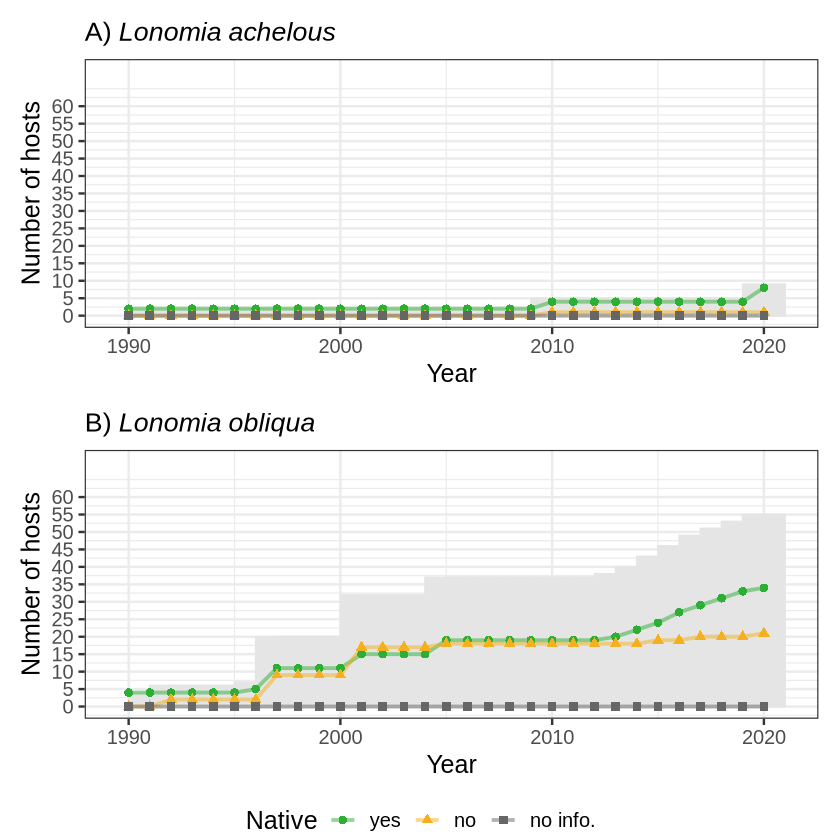

In [124]:
# Get the legend of 'species1' plot with its position set to the bottom.
# 'get_legend' function extracts the legend from a ggplot. 
leggraph <- get_legend(species1 + theme(legend.position = "bottom")) 

# The 'plot_grid' function arranges multiple ggplots into a grid.
# Here, it is used to stack 'species1' and 'species2' plots in one column (ncol = 1). 
# The legends for these individual plots are removed using `theme(legend.position = "none")`.
two_graphs <- plot_grid((species1 + theme(legend.position = "none")) / (species2 + theme(legend.position = "none")), ncol = 1)


# Here, we add the legend:
with_legend <- plot_grid(two_graphs, leggraph, ncol = 1, align = "v", rel_heights = c(1, .05))
with_legend

In [125]:
# 'svg' is a function in R to start a new device driver that produces Scalable Vector Graphics (SVG). 
# This outputs graphical representations to a file or a connection, in this case a SVG file named "fig_hosts_native_time.svg".

# 'width' and 'height' arguments define the size of the image in inches.
# Here, the width and height of the plot are set to 8 inches and 11 inches respectively.

svg("images/fig_hosts_native_time.svg", width = 8, height = 11)

# 'print' is used to print the plot object 'with_legend' on the current plotting device, which is an SVG file in this case.
# It will output the 'with_legend' plot into the SVG file we created above.

print(with_legend)

# 'dev.off()' is a function that shuts down the current (or specified) device. 
# In this case, it turns off the SVG file device that was turned on earlier. 
# This is necessary because it finalizes the file for use by adding necessary closing tags etc.

dev.off()

png 
  2

In [126]:
# Save the current plot to an image using `agg_tiff` from the ragg package.
# The image will be titled 'especies_tempo.tiff', having dimensions of 8x11 inches with a resolution of 400 DPI.
ragg::agg_tiff("images/especies_tempo.tiff", width = 8, height = 11, units = "in", res = 400)

with_legend

# Turns off the device that was turned on with ragg::agg_tiff and finalizes the image file.
dev.off()

png 
  2

In [127]:
# # ===========================================================================================================================
# # EXTRA - not used! 
# # Defining a function named 'plotter'.
# # This function creates a ggplot bar chart plot using given data, title, and y-axis ticks.
# plotter <- function(data, title, ticks){
  
#   # Create a bar chart with stacks for each category of 'native'.
#   # Sets labels for the chart title, x-axis, y-axis and fill legend. 
#   # Limits the x-axis from 1989.5 to 2020.5 and the y-axis from 0 to 70 with provided ticks.
#   ggplot(data, aes(fill = Native, y = aggregate_n_for_that_year, x = min_year)) + 
#     geom_bar(position="stack", stat="identity") +
#     labs(title = title,
#          fill = "Native",
#          x = 'Year',
#          y = 'Number of species') +
#     xlim(1989.5, 2020.5) +
#     scale_y_continuous(breaks = ticks, limits = c(0,70)) +
#     theme_bw() # Applies a theme to the plot.
  
# }

In [128]:
# # Generate a plot of Lonomia achelous' host species over the years 1978 to 2020, aggregated by hosts status.
# # The y-axis ticks range from 0 to 70 in increments of 5.
# # This plot is prepared using the 'plot_preparer' function and then plotted using the 'plotter' function.
# # The prepared plot is stored in the variable `species1`.
# species1 <- host_species |>
#     plot_preparer(filter = "Lonomia achelous", aggregation = lonomia_species, 1978:2020) |>
#     plotter("Lonomia achelous' host species, throughout the years, aggregated by hosts' status", seq(0, 70, by = 5))

# # Similar to above, but for 'Lonomia obliqua' for the years 1968 to 2020.
# # Stored in the variable `species2`.
# species2 <- host_species |>
#     plot_preparer(filter = "Lonomia obliqua", aggregation = lonomia_species, 1968:2020) |>
#     plotter("Lonomia achelous' host species, throughout the years, aggregated by hosts' status", seq(0, 70, by = 5))

# # Combine the `species1` and `species2` plots vertically using the `/` operator of the patchwork package.
# # Annotate the combined plot with a title and subtitle using the 'plot_annotation' function.
# # The resulting plot is stored in the `final` variable.
# final <- patchwork::wrap_plots(species1 / species2) + patchwork::plot_annotation(
#     title = "Becoming a generalist?",
#     subtitle = "The number of host species the Lonomia catterpillars are found on has increased since the 60s"
# )